# Qubit Routing challenge

Welcome to the **Qubit Routing Challenge** of the MQST Qiskit Fall Fest 2025!

In this challenge you will learn to peek inside `QuantumCircuits` and change gates and its parameters, in order to  map logical quantum circuits, into actual physical restricted topologies of real hardware. Both manually looping through the objects, and with automated tools provided by qiskit.


#### First install the necessary packages:

In [ ]:
# Uncomment to install the necessary packages

%pip install --upgrade pip
%pip install numpy==2.3.4
%pip install scipy==1.16.2
%pip install matplotlib==3.10.7
%pip install jupyter
%pip install qiskit[visualization]==2.2
# # For Local Linux or Mac, you can use the following command:
# # %pip install 'qiskit[visualization]'
%pip install qiskit_algorithms==0.4.0
%pip install qiskit_aer==0.17.2
%pip install qiskit_ibm_runtime==0.41.1
%pip install qiskit_ibm_transpiler==0.14.3

---

# Introduction

In the digital model of quantum computation, a crucial type of operation that enables interaction between qubits is the **two-qubit gate**, which acts on one or two qubits at a time. In practical hardware, however, qubits are typically arranged in a fixed two- or three-dimensional topology where gates can only be applied between physically connected qubits. Therefore, to execute a circuit on such hardware, it must be adapted to ensure that any pair of qubits required to interact are connected.

The process of modifying a circuit to match the memory layout of a particular quantum device is known as the qubit routing problem. When two non-adjacent qubits need to interact, additional SWAP gates can be inserted to exchange the state of a qubit with that of a neighboring connected qubit, effectively moving its state until it reaches the desired partner. In general, many—or even all—of the qubits may need to be swapped, making this a non-trivial challenge. Because quantum algorithms are typically designed without regard to the connectivity constraints of a specific hardware platform, resolving the routing problem is essential before executing a circuit. Consequently, qubit routing forms a necessary stage in any quantum compiler.

<p style="text-align: center"><img src="https://i.imgur.com/7KvVAF5.png" width=700 /></p>

FIG. 0 The transpiler takes an abstract (theoretical) quantum circuit as input and produces an optimized physical quantum circuit (ready for execution on real hardware) as output. Adapted from 10.48550/arXiv.2306.15020.

Current quantum computers—known as NISQ (Noisy Intermediate-Scale Quantum) devices—introduce additional constraints. Their short coherence times and relatively low gate fidelities demand that both the circuit depth and the total number of gates be kept as small as possible. Since routing generally introduces extra gates, increasing circuit size and depth, it is vital to ensure that these overheads remain minimal to preserve performance.

We can represent a quantum computer as a graph where nodes correspond to physical qubits and edges denote allowable two-qubit interactions. In the theoretical circuit model, we assume that a two-qubit gate can be applied between any pair of qubits, corresponding to a complete graph (Fig. 1a). Realistic hardware, however, has limited connectivity: for instance, superconducting qubit platforms are typically planar, while ion traps offer more flexibility but are still not fully connected. For simplicity, we consider the ring graph (Fig. 1b) as an illustrative example. Given such restricted connectivity, the goal is to emulate the complete graph with minimal additional cost.

From this perspective, the routing problem can be defined as follows. Given *(i)* an arbitrary quantum circuit and *(ii)* a connected graph specifying the permitted qubit interactions, we must generate a new circuit equivalent to the original but restricted to the allowed interactions. Provided the device contains at least as many qubits as the input circuit, a valid solution always exists; our aim is to minimize the size of the resulting circuit.


<p style="text-align: center"><img src="https://i.imgur.com/eH9Wyoh.png" width=500 /></p>

*FIG.1 Nodes in the graph represent physical qubits and edges are the allowed interactions. (a) The circuit
model assumes all-to-all communication between qubits, *i.e*. a complete graph and (b) a physically realistic
one-dimensional nearest neighbour cyclic graph, the ring.*


### Some helper functions, for plotting:

In [3]:
from matplotlib.pyplot import figure
from qiskit import QuantumCircuit


def plotting_circuit_with_title(circuit: QuantumCircuit, title: str):
    """Plots the given Quantum Circuit, with the passed title.

    Args:
        circuit (QuantumCircuit): The quantum circuit to plot together with its title.
        title (str): Title of the plot.
    """
    ax = figure().add_subplot()
    ax.set_title(title)
    circuit.draw(output="mpl", ax=ax)

    return ax


def adding_timeslices_to_circuit_plot(circuit: QuantumCircuit, title: str, timeslices: list[float]):
    """This function adds vertical lines to the circuit plot to divide the circuit into time slices.

    Args:
        circuit (QuantumCircuit): The quantum circuit to plot together with the time slices.
        timeslices (list): A list of floats representing the horizonal positions of the time slices to plot.
    """

    ax = plotting_circuit_with_title(circuit, title)

    # divide the circuit into time slices
    for x in timeslices:
        ax.axvline(x, color="red", linestyle="--")


## A. Example: routing on a ring

Let’s consider the problem of routing the following circuit (FIG.2) on the ring graph of FIG. 1(b).

<Axes: title={'center': 'FIG. 2'}>

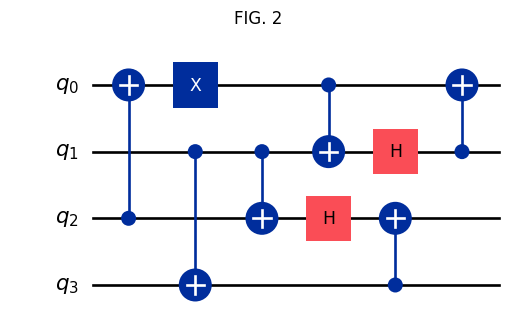

In [4]:
from qiskit import QuantumCircuit

# Creating the circuit:
c = QuantumCircuit(4)
c.cx(2, 0)
c.cx(1, 3)
c.x(0)
c.cx(1, 2)
c.cx(0, 1)
c.h(1)
c.h(2)
c.cx(1, 0)
c.cx(3, 2)

# Plotting circuit with title
plotting_circuit_with_title(circuit=c, title="FIG. 2")

The first step is to divide the circuit into timesteps, also called slices. Loosely speaking, a timestep consists of a subcircuit where the gates act on disjoint sets of qubits and could in principle all be performed simultaneously. The single qubit gates have no bearing on the routing problem so can be ignored, and thus a timestep can be reduced to a set of qubit pairs that are required to interact via some 2-qubit gate. 

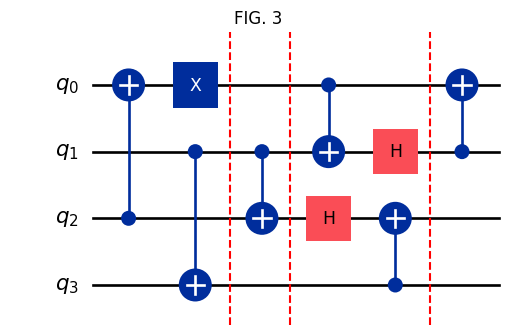

In [17]:
# These time slices, represent the 2-qubit gates that can be executed in parallel:
timeslices = [1.3, 2.2, 4.3]  # (These values are approximatel obtained by visual inspection of the circuit plot)

# Calling the function, with your given parameters:
adding_timeslices_to_circuit_plot(circuit=c, title="FIG. 3", timeslices=timeslices)

Next, the virtual qubits of the circuit ($q_k$) must be mapped to the nodes of the graph ($K$, physical qubits). For our example a reasonable initial mapping is $q_0 \rightarrow 0, q_1 \rightarrow 2, q_2 \rightarrow 1, q_3 \rightarrow 3$ as shown in FIG. 4. This has the advantage that the qubits which interact in the first timestep (q0 with q2, and q1 with q3) are connected in the graph, and the same for the second timestep (q1 with q2).

<p style="text-align: center"><img src="https://i.imgur.com/uA65Mwv.png" width=500 /></p>

*FIG. 4. (a) An initial mapping of virtual qubits to nodes. (b) How the graph ends. Highlighted nodes are labelled with the mapped qubit.*

However at the third timestep our luck has run out: the CNOT gate between $q_0$ and $q_1$ is not possible in the current configuration. We must add SWAP gates to exchange virtual qubits to enable the desired two-qubit interactions. In the example there are two candidates: swapping nodes 0 and 1, or swapping nodes 1 and 2, yielding the configurations shown in FIG. 5.

<p style="text-align: center"><img src="https://i.imgur.com/LkJSYzj.png" width=550 /></p>

*FIG. 5. (a) Qubit mapping to nodes if $q_0$ and $q_2$ swap positions. (b) Qubit mapping to nodes if $q_1$ and $q_2$ swap positions.*

But considering the rest of the current slice, we see that $q_2$ and $q_3$ will need to interact too. In configuration (a) these qubits are distance 3 apart, and hence two additional swaps will be needed to bring them together. In configuration (b) however they are already connected. As we want to minimise the number of additional elements to our circuit we choose configuration (b), swaping nodes 1 and 2 to yield the final circuit you need to construct in FIG. 6.

In [ ]:
from qiskit import QuantumCircuit

routed_c = QuantumCircuit(4)
routed_c.cx(1, 0)  # Adding first CNOT, for reference

# Your code goes here, continue the circuit:
#
#

routed_c.swap(2, 1)  # Adding the middle and unique needed SWAP

# Your code goes here, finish the circuit:
#
#

print(f"Circuit detph: {routed_c.depth()}")
plotting_circuit_with_title(circuit=routed_c, title="FIG. 6")

Another way to see this case, is by thinking about the ring topology needing all 2-qubit gates, to connect near lines in our quantum circuit. But since our original circuit, doesn't fullfill this we need to start interchagning the 2 middle qubits ($q_0 \rightarrow 0, q_1 \rightarrow 2, q_2 \rightarrow 1, q_3 \rightarrow 3$) to achieve this, and then, when we arrive to slice 3, given this changed we did, the gates don connect near circuit lines, and we need to put them back as they were before the mapping with a $SWAP$.

While this was a tiny example we can see in microcosm all the key elements of the problem: the need to find a mapping of qubits to nodes; the notion of distance between qubits at the next
timestep; and the need to compute the permutation of the nodes to enable the next timestep. It should be clear even from this small example that as the size of the circuit increases the number of candidate swaps increases dramatically. Further, if we have to swap several pairs of qubits at the same time, improving the situation for one pair may worsen the situation for another pair. There is a clear arbitrage to apply to bring all the pairs together as soon as possible. Our goal is to optimise the circuit globally so finding optimal mappings between timesteps is
not sufficient. It is necessary to evaluate candidate mappings across multiple timesteps; this is the core of a good routing algorithm.

## B. DAG representation of Quantum Circuits:

The manual process we just did in part A., for bigger circuits, can be tricky to see directly. A good practice, and what most software do, is getting the equivalent Direct Acyclic Graph (DAG) representation of the Quantum Circuit, where the nodes and edges have the opposite role: edges are qubits, and nodes are 2-qubit gates.

This is equivalent to moving all the gates to their maximum left in the circuit, until they find a previous dependency, that stops it. In this case, the DAG representation of our circuit is (1q gates, removed for more easily see the dependencies):

<p style="text-align: center"><img src="https://i.imgur.com/aOCC2aZ.jpeg" width=500 /></p>


*FIG. 7. Direct Acylcic Graph (DAG) representation of the Quantum Circuit, using networkx library and the "dot" ploting configuration.*

Where for example, now we have the time dependencies ordered in slices directly, at each height of the DAG. Notice how the first two $CX$s are in the same timeslice, and also notice how the $CX(3,2)$ on the bottom right, is clearly in the same time slice than the $CX(0,1)$ and not the $CX(1,0)$.


## C. SWAP synthesis and routing

In the preceding section we described the routing problem in terms of inserting SWAP gates into
the circuit. However these interactions may be asymmetric. For example, in some devices, the 2-qubit interaction is a CNOT where one qubit is always the control and the other always the target. The graph representing the machine is therefore directed, as shown in FIG. 8, where the direction indicates the orientation of the gate.

<p style="text-align: center"><img src="https://i.imgur.com/iEDqebl.png" width="250" /></p>

*FIG. 8. Architecture with one-way connectivity constraint.*


This complication is easily removed by the usual trick of inserting Hadamard gates, as FIG. 9.

<p style="text-align: center"><img src="https://i.imgur.com/fpzOqp0.png" width=400 /></p>

*FIG. 9. Inverting a CNOT gate for a directed graph.*

Hence the swap gate can be implemented by three (unidirectional) CNOTS and four Hadamards, as in FIG. 10.

<p style="text-align: center"><img src="https://i.imgur.com/1A8OGRU.png" width=600 /></p>

*FIG. 10. Representation of a SWAP gate in terms of three consecutive CNOT and its inverted representation for a directed graph.*

Consider running our routed quantum circuit on the directed architecture of FIG. 8. As this
graph constrains the direction of interactions, the quantum circuit we produced is no longer valid. We account for this using the inversion in FIG.9, producing the circuit shown in FIG.11. 

(Lets say, We have available the lesser qubit as the control, and the bigger as the target, like: $CNOT(0,1)$, $CNOT(1,2)$, $CNOT(2,3)$, ...)

In [ ]:
from qiskit import QuantumCircuit


def add_reversed_CNOT(circuit: QuantumCircuit, old_control_q: int, old_target_q: int) -> QuantumCircuit:
    """Returns a circuit, with the added, changed directions (reversed), CNOT gate (1 CNOT and 4 Hadamarts).

    Args:
        circuit (QuantumCircuit): Circuit to add the reversed CNOT gate.
        old_control_q (int): Qubit number, that was previously the control.
        old_target_q (int): Qubit number, that was previously the target.

    Returns:
        QuantumCircuit: Circuit with the added reversed CNOT gate (1 CNOT and 4 Hadamarts).
    """
    # Your code goes here:
    #
    #

    return circuit


def add_decomposed_unidirectional_SWAP(circuit: QuantumCircuit, new_control_q: int, new_target_q: int) -> QuantumCircuit:
    """Returns a circuit, with the added decomposed unidirectional SWAP gate (3 CNOTS and 4 Hadamarts).

    Args:
        circuit (QuantumCircuit): Circuit to add the reversed CNOT gate.
        new_control_q (int): Qubit number, to use as a control now.
        new_target_q (int): Qubit number, to use as a target now.

    Returns:
        QuantumCircuit: Circuit with the added decomposed unidirectional SWAP gate (3 CNOTS and 4 Hadamarts).
    """
    # Your code goes here:
    #
    #

    return circuit


directional_c = QuantumCircuit(4)
directional_c = add_reversed_CNOT(directional_c, 1, 0)
directional_c.cx(2, 3)
directional_c.x(0)
directional_c = add_reversed_CNOT(directional_c, 2, 1)
directional_c = add_decomposed_unidirectional_SWAP(directional_c, 1, 2)
directional_c.cx(0, 1)
directional_c.h(1)
directional_c.h(2)
directional_c = add_reversed_CNOT(directional_c, 1, 0)
directional_c = add_reversed_CNOT(directional_c, 3, 2)

print(f"Circuit detph: {directional_c.depth()}")
directional_c.draw(output="mpl")

*FIG. 11*


Many simplifications are possible on the resulting circuit, but care must be taken to ensure that the simplified circuit is still conformant to the architecture digraph. But for example, the most trivial cancellations, we will see later, are $H-H=X-X=CNOT-CNOT=I$, leaving the above circuit, more simple as in the next FIG. 12:

> Notice: For the below circuit to be correct, the above function need to be defined correctly.

> Also, in principle, **you should NOT add anything here**

In [ ]:
from qiskit import QuantumCircuit

simplified_directional_c = QuantumCircuit(4)
simplified_directional_c.h(0)
simplified_directional_c.h(1)
simplified_directional_c.cx(0, 1)
simplified_directional_c.cx(2, 3)
simplified_directional_c.h(0)
simplified_directional_c.x(0)
simplified_directional_c.h(2)

simplified_directional_c = add_decomposed_unidirectional_SWAP(simplified_directional_c, 1, 2)

simplified_directional_c.h(1)
simplified_directional_c.h(2)
simplified_directional_c.cx(1, 2)

simplified_directional_c.cx(0, 1)

simplified_directional_c.h(0)
simplified_directional_c.cx(0, 1)
simplified_directional_c.h(0)
simplified_directional_c.h(1)

simplified_directional_c.h(3)
simplified_directional_c.cx(2, 3)
simplified_directional_c.h(2)
simplified_directional_c.h(3)

print(f"Circuit detph: {simplified_directional_c.depth()}")
simplified_directional_c.draw(output="mpl")

*FIG. 12*

# 0- First non-trivial coding:

Define a function, that loops around a circuit, finding 2 qubit gates that don't have the proper direction, and redirects them, using the above `add_reversed_CNOT(...)` function.

(You can asume, that any pair in the circuit, has already the correct pairing. Only the direction of such pairing can be wrong, ex: $CX(1,0)$ instead of $CX(0,1)$, but no $CX(2,0)$.)

> !!! Notice: The given empty functions are there to make your life and the organizers life easier, with a common frame, but if you think of another solutions go for it !!!

In [ ]:
from qiskit import QuantumCircuit

direct_topology = [(0, 1), (1, 2), (2, 3), (3, 0)]  # CX(control, target) can be done with this order of tuples (control, target)


def gates_of_circuit(circuit: QuantumCircuit) -> list[tuple]:
    """Returns a list of tuples, each containing the gate name and the qubits it acts on from the circuit.

    Args:
        circuit (QuantumCircuit): Circuit to extract the gates from.

    Returns:
        list[tuple]: List of tuples, each containing the gate name and the qubits it acts on: [(gate_name1, qubits1), (gate_name2, qubits2), ...]
            Where the qubits for each gate is a list, as [single_qubit] or [control_qubit, target_qubit].

    """
    circuit_gates_list = []
    # Your code goes here
    #
    #

    return circuit_gates_list  #  [(gate_name1, qubits1), (gate_name2, qubits2), ...], with qubits as [single_qubit] or [control_qubit, target_qubit]


def construct_circuit_from_gates(gates: list[tuple], num_qubits: int) -> QuantumCircuit:
    """Returns a QuantumCircuit, constructed from the passed list of gates.

    Args:
        gates (list[tuple]): List of tuples, each containing the gate name and the qubits it acts on: [(gate_name1, qubits1), (gate_name2, qubits2), ...]
        num_qubits (int): Number of qubits in the circuit.

    Returns:
        QuantumCircuit: Constructed circuit from the passed list of gates.
    """
    circuit = QuantumCircuit(num_qubits)

    # Your code goes here
    # Hint: if string=="cx", then circuit.__getattribute__(string)(qubit1, qubit2), will be the same as circuit.cx(qubit1, qubit2)
    #
    #
    return circuit


def redirect_circuit(circuit: QuantumCircuit, directed_topology: list[tuple]) -> QuantumCircuit:
    """Redirects a circuit, so all 2qubit gates, can be done in a directed topology. Function assumes all the circuit connections
    are contained inside the passed topology, with correct or incorrect directions (but not with incorrect pairing).

    Args:
        circuit (QuantumCircuit): Circuit to redirect 2q gates.
        directed_topology (list[tuples]): Available directions of the topology, to check the gates with.

    Returns:
        QuantumCircuit: Redirected circuit.

    """
    circuit_gate_list = gates_of_circuit(circuit)

    # Pass all gates into the new list, reordering the needed ones
    redirected_gate_list = []

    # Your code goes here
    #
    #

    # Build a circuit from the new list:
    return construct_circuit_from_gates(redirected_gate_list, circuit.num_qubits)

### Finally, lets test if it worked:

> In principle, **you shouldn't change anything below here** (if you followed the above formats). vvv

#### First, the one that needs to remain invariant, since it already is correctly directed:

In [ ]:
# Testing it works:
already_redirected_circuit = redirect_circuit(simplified_directional_c, direct_topology)
assert gates_of_circuit(simplified_directional_c) == gates_of_circuit(already_redirected_circuit)
print("All test passed!")

# Doing original draw of circuit:
simplified_directional_c.draw(output="mpl")

And we need to obtain the same, now, with its redirected version:

In [ ]:
already_redirected_circuit.draw(output="mpl")

#### And now, lets do it with the `routed_c` from before, that was not directed, and see it ends up correctly directed, now:

In [ ]:
# Testing it works:
new_redirected_c = redirect_circuit(routed_c, direct_topology)
assert gates_of_circuit(routed_c) != gates_of_circuit(new_redirected_c)
print("All test passed!")


# Doing original draw of circuit:
routed_c.draw(output="mpl")

And finally to see, if it has correctly added the needed re-directions and Hadamart gates:


In [ ]:
new_redirected_c.draw(output="mpl")

---

# LET'S START THE ACTUAL CHALLENGE:

## Star topology

If we have access to a 5-qubit digital chip with a star topology (FIG.13). In this topology, all two-qubit gates need to be implemented using the central qubit as a mediator. You can start by considering that the central qubit is bidireccional, i.e., it can be used as a control or target qubit. 

<p style="text-align: center"><img src="https://i.imgur.com/tVLBLaG.png" width=400 /></p>

*FIG.13: Star topology with 5 qubits.*

# 1- First real challenge

Now consider the following circuit from FIG.14. Your mission is to implement this circuit in the star topology by following the steps below:


Depth of circuit:  <bound method QuantumCircuit.depth of <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7186393ee300>>


<Axes: title={'center': 'FIG. 14: Given circuit'}>

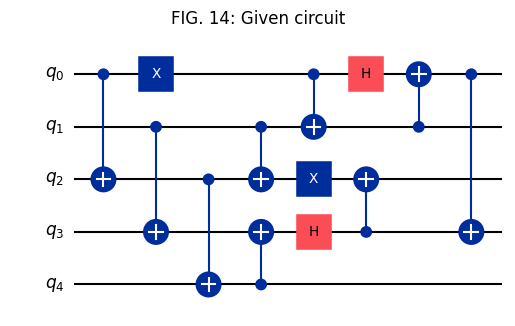

In [19]:
c = QuantumCircuit(5)
c.cx(0, 2)
c.cx(2, 4)
c.cx(1, 3)
c.x(0)
c.cx(4, 3)
c.cx(1, 2)
c.cx(0, 1)
c.x(2)
c.h(0)
c.h(3)
c.cx(1, 0)
c.cx(3, 2)
c.cx(0, 3)

print("Depth of circuit: ", c.depth)
plotting_circuit_with_title(c, "FIG. 14: Given circuit")


### 1.1. Divide the circuit into timeslices.

In [ ]:
# Divide the circuit into time slices
timeslices = [...]  # Visually, add floats representing the time slices approximately

adding_timeslices_to_circuit_plot(c, "FIG. 14.b: Given circuit with time slices", timeslices)

### 1.2. Determine the initial placement of the qubits such that the maximum number of two-qubit gates can be implemented without SWAPS. This may not be trivial to see so you can always try a random placement, the only problem is that you will have to implement more SWAPS, which is the metric we want to minimize throughout the challenge.

In [8]:
c_optimal_layout = ...  # Solution here


### 1.3. Once the initial placement is defined, how many extra SWAPS do you need to implement the circuit? 

In [ ]:
routed_c = QuantumCircuit(5)

# Your code goes here
#
#

print("Depth of circuit: ", routed_c.depth)
plotting_circuit_with_title(routed_c, "FIG 14.c: Given circuit, routed to the star topology.")


### 1.4. Now imagine that the central qubit is unidirectional (the case of real quantum hardware), i.e., it can only be used as a control qubit. How much does the depth of the circuit increase in this case?

In [ ]:
# Use the previous functions from the `Intro.ipynb`` notebook!

directional_c = QuantumCircuit(5)

# Your code goes here
#
#

print("Depth of circuit: ", directional_c.depth)
plotting_circuit_with_title(directional_c, "FIG 14.d: Given circuit, routed to the star topology, with directional CNOTs.")

### 1.5. Is there any trivial gate cancellation that can be done to reduce the depth of the circuit? (i.e. two CNOTs in sequence are just the identity. Same with two contiguous Hadamards).

In [ ]:
optimized_c = QuantumCircuit(5)

# Your code goes here
#
#

print("Depth of circuit: ", optimized_c.depth)
plotting_circuit_with_title(optimized_c, "FIG 14.e: Given circuit, optimized for the given directional topology.")


### 1.6. Give a method to verify that your resulting circuit represents the same unitary as the original one, i.e. both circuits are equivalent (Watch out with the initial mapping changing the qubits you are refering to)

In [12]:
import numpy as np

from copy import deepcopy


def circuits_equivalence_fidelity(og_circuit, transp_circuit, layout):
    """Check if two circuits are equivalent.

    Args:
        og_circuit (QuantumCircuit): Original circuit to compare.
        transp_circuit (QuantumCircuit): Transpiler circuit to compare.
        layout (dict): Layout used for the transpiled circuit.

    Returns:
        float: Fidelity between the two circuits.
    """

    # Your code goes here
    #
    #

    return fidelity

#### Testing circuit equivalence fidelity, with previous notebooks:

In [ ]:
circuits_equivalence_fidelity(c, optimized_c, c_optimal_layout)

# 2- Different topology

Until now, we have been using only the Star topology:

In [22]:
star_coupling_map = [[0, 2], [1, 2], [2, 3], [2, 4]]

Consider now the following topology for a 5-qubit chip: the linear chain topology (FIG.15). Follow the previous steps and compare the number of SWAPS needed to implement the circuit from FIG.14 in this new topolgy. **What conclusions can you draw from this comparison?**

----
### Linear topology:

<p style="text-align: center"><img src="https://i.imgur.com/vKNOWlh.png" width=400 /></p>

*FIG.15: Chain topology with 5 qubits*

In [78]:
# You won't need to use them now, since this exercise is manual, but later you will.
linear_coupling_map = [...]  # Define the linear coupling map

# Your code goes here:
#
#

# 3- Using qiskit tools for transpilation

### Using Qiskit own layout and routing [Transpiler Passes](https://docs.quantum.ibm.com/api/qiskit/transpiler_passes) algorithms, run the previous circuits and compare it with your results.

> To learn how to use qiskit transpilation, check this guide: https://quantum.cloud.ibm.com/docs/en/guides/transpile-with-pass-managers

> For a more advanced understanding, building your own Passes and Custom Tranpiler, check: [QGSS/lab1](https://github.com/qiskit-community/qgss-2024/blob/main/solutions/lab1/lab1_solution.ipynb) and [IBM_QC/lab2](https://github.com/qiskit-community/ibm-quantum-challenge-2024/blob/main/solutions/lab_2/lab-2-solution.ipynb).


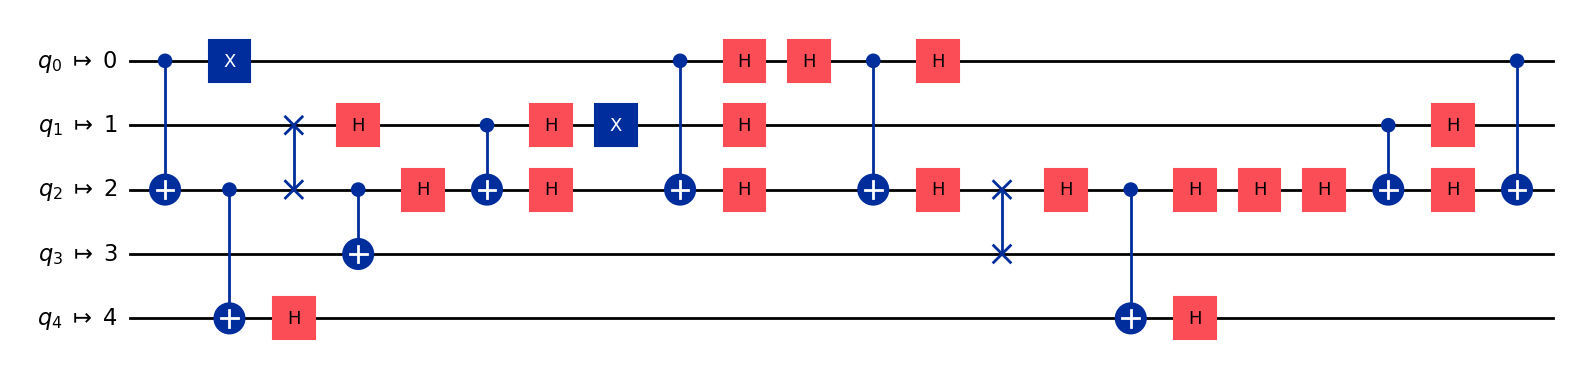

In [28]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator

simulator = AerSimulator()

star_transpiler_lv0 = generate_preset_pass_manager(coupling_map=star_coupling_map, optimization_level=0, seed_transpiler=1234)

transpiled_c_lv1 = star_transpiler_lv0.run(c)
transpiled_c_lv1.draw(output="mpl")

### Run at least 4 or 6 different combinations of Topologies, Layout and Routing Passes, from the offered by Qiskit:

For example, try:
- The default IBM settings, like above, with different `optimization_levels`
   
   (can you guess/find, which Layout and Routing passes its using?) 

- Use combinations of the `TrivialLayout`, `SabreLayout`, `DenseLayout` with the Routing Pass: `SabreSwap`.

- Choose some other Routing Pass aswell, like: `BasicSwap`, `LookaheadSwap`, etc.. with the Layout pass that you liked the most.

#### Default IBMs, with different optimizations:

In [29]:
# Your code goes here:
#
#

#### SABRE Routing with different combinations of Layouts:

In [31]:
sabre_star_transpiler_lvl1 = generate_preset_pass_manager(
    coupling_map=star_coupling_map,
    layout_method="sabre",
    routing_method="sabre",
    optimization_level=1,
    seed_transpiler=1234,
)

# Your code goes here:
#
#

#### Change the Routing Pass, with the Layout you liked the most:

In [82]:
# Your code goes here:
#
#

#### Now with another topology:

In [ ]:
linear_transpiler_lv1 = generate_preset_pass_manager(coupling_map=linear_coupling_map, optimization_level=1, seed_transpiler=1234)

# Your code goes here:
#
#

### Since we see, that depending on the executions, we get different number of SWAP gates...
### Do an iterator, that tries several times, and keeps the best result:

In [ ]:
def find_best_routing(circuit: QuantumCircuit, optimization_level: int, coupling_map: list, iterations=10):
    """Iterate, through different Find the best routing for a given circuit.

    Args:
        circuit (qiskit.QuantumCircuit): Circuit to route.
        optimization_level (int): Optimization level to use.
        coupling_map (list): Coupling map of the target device.
        iterations (int): Number of iterations to run.

    Returns:
        qiskit.QuantumCircuit: Best routed circuit.
        dict: Final layout, of the chosen best circuit.
    """

    simulator = AerSimulator()

    transpiler = generate_preset_pass_manager(optimization_level, coupling_map=coupling_map)

    best_transpiled_circuit = ...
    best_layout = ...

    for _ in range(iterations):
        transpiled_c = transpiler.run(circuit)

        # Your code goes here:
        #
        #


Lets test it:

In [ ]:
coupling_map = ...  # Define your coupling map
optimization_level = ...  # Choose your optimization level

best_transpiled_c, final_c_layout = find_best_routing(c, optimization_level, coupling_map, iterations=100)

best_transpiled_c.draw(output="mpl")
print("Transpilation Fidelity: ", circuits_equivalence_fidelity(c, best_transpiled_c, final_c_layout))

Finally, try and play with the other parameters from IBM pass manager, such as:
- basis_gates
- approximation_degree
- ...

And see, how the gates, of your circuit changes automatically, to the equivalent circuit with the new given_basis, or how you start to get much smaller circuits, in exchange of some extra compilation error.

In [ ]:
basis_gates = ["ecr", "id", "rz", "sx", "x"]  # Try this new basis gates, for example

# Your code goes here:
#
#

# 4- Code your own Routing (Truly challenging - research level)

### Implement your own router from 0, so you will appreciate, more the given tools by qiskit :)

In real hardware, we have a fixed topology and a rich variety of circuits, with different connectivies and so on. Most likely the circuit executable will not be directly mappable to the topology of the hardware. It is imperative to have a compilation procedure that, among other tasks, deals with the qubit routing. In this exercise, we will design our own algorithm for qubit routing, beware that this is not a trivial task! 

The algorithm proceeds in four stages: 
- decomposing the input circuit into timesteps (optional, but recommended); 
- determining an initial placement; 
- routing across timesteps;
- and a final clean-up phase (optional).

We will design the qubit routing algorithm using a brand new circuit ( below) on the star-topology (FIG.13) but, once finished, we can test it on the circuits and topologies from the previous exercises. 

#### Check these papers, for more info on the posible algorithms: Originally https://arxiv.org/pdf/2003.10611 (but this is also a very used algorithm, you can base yourself on: https://arxiv.org/pdf/1809.02573)

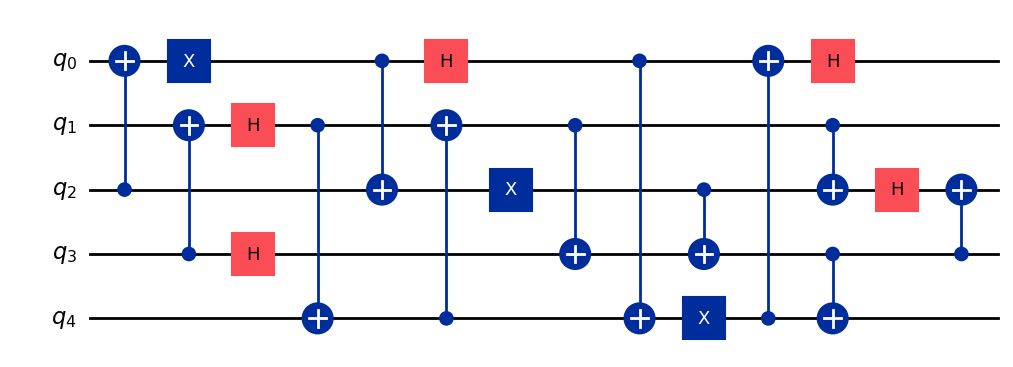

In [16]:
circuit = QuantumCircuit(5)

circuit.cx(2, 0)
circuit.cx(3, 1)
circuit.x(0)
circuit.h(1)
circuit.cx(1, 4)
circuit.cx(0, 2)
circuit.h(3)
circuit.cx(4, 1)
circuit.x(2)
circuit.cx(1, 3)
circuit.h(0)
circuit.cx(0, 4)
circuit.cx(2, 3)
circuit.x(4)
circuit.cx(4, 0)
circuit.cx(1, 2)
circuit.h(2)
circuit.h(0)
circuit.cx(3, 4)
circuit.cx(3, 2)

circuit.draw(output="mpl")

> IMPORTANT!!!

> All the next explanations will try to explain the next needed steps. But if you can figure it by yourself, don let them confuse you.

### A. (Recomended, not mandatory) Slicing the circuit into timesteps

Before performing routing, we first partition the quantum circuit into timesteps. The circuit’s structure naturally defines a partial ordering of the gates, allowing a greedy algorithm that begins from the inputs to divide the circuit into “horizontal” layers of gates that can be executed simultaneously. As we traverse the circuit, we add the qubits involved in each two-qubit gate to the current timestep. Since only multi-qubit interactions (such as CNOT or CZ gates) impose connectivity constraints, single-qubit gates can be temporarily ignored.
(More precisely, while single-qubit gates can be disregarded for the purpose of routing, they must still be preserved for circuit reconstruction; for simplicity, we omit them here.)

If a gate involves a qubit that was already used in the current timestep, a new timestep is created. This process is repeated until all gates have been assigned to a timestep. Each timestep therefore consists of a set of disjoint pairs of (virtual) qubits, representing the gates scheduled for simultaneous execution.

In [20]:
def generate_timesteps(circuit: QuantumCircuit) -> list[list[tuple]]:
    """
    Function to determine the timesteps of a given circuit

    Args:
        circuit (Qibo circuit): qibo circuit to determine the timesteps

    Returns:
        timesteps (list): list of timesteps with the qubits involved in each timestep
    """

    # Your code goes here:
    #
    #

    return timesteps

### B. Initial Mapping

For the routing algorithm to begin, we first need an initial mapping between the virtual qubits (hereafter referred to simply as qubits) and the physical qubits (referred to as nodes).

We iterate over the timesteps to construct a graph whose nodes represent qubits. At timestep n, we add an edge  $(q,q′)$ to the graph if (i) this pair appears in the timestep, and (ii) both qubits $q$ and $q′$ have degrees (number of edges connected to them) less than 2 in the current graph. When constructed correctly, each connected component of the resulting graph is either a line or a ring; rings are then broken by removing an arbitrarily chosen edge.

Disconnected qubits in this graph correspond either to qubits that never interact or to those whose first interaction is with a qubit whose initial interactions are already with others. These disconnected qubits can be ignored for the purpose of the initial placement—they will be incorporated later during the routing process.

Once this graph is obtained, select a subgraph of the hardware architecture with a high average degree and low diameter as the starting point. The qubit graph can then be mapped onto the architecture as a single long line, beginning from a high-degree vertex within the chosen subgraph and greedily selecting the highest-degree available neighbor. This approach ensures that most of the gates in the first two timesteps can be executed without requiring any SWAP operations. The only exceptions are the gates corresponding to edges removed when breaking the rings.

If the initial mapping cannot be completed as a single continuous line, it should be divided and mapped as several line segments.

Implement the initial_mapping function, which takes the timesteps as input and outputs the initial mapping as a dictionary.
 

In [368]:
def initial_mapping(timesteps: list) -> dict[int, int]:
    """
    Function to determine the initial mapping of the qubits to the architecture.

    Args:
        timesteps (list): list of timesteps with the qubits involved in each timestep

    Returns:
        dict: dictionary with the initial mapping of virtual qubits (referred to as qubits) to physical qubits (referred to as nodes)
    """

    # Your code goes here:
    #
    #

    return mapping


### C. Routing


The routing algorithm we aim to implement iteratively constructs a new circuit that conforms to the desired hardware architecture, taking as input the sliced circuit and the current mapping of qubits to nodes.

At each step, the algorithm compares the current timestep of the input circuit with the existing qubit-to-node mapping. If a gate in the current timestep involves a qubit that has not yet been mapped, it is assigned to the nearest available node to its partner. All gates that can be executed under the current mapping—namely, all single-qubit gates and two-qubit gates whose operands are connected—are immediately removed from the timestep and added to the output circuit. If this exhausts the current timestep, the algorithm advances to the next one; otherwise, SWAPs must be added.

You will need to define a distance vector $d(s, m)$ that approximates the number of SWAPs required to make timestep $s$ executable under the mapping $m$. These vectors should be ordered pointwise. Let $s_0$ denote the current timestep, $s_1$ its successor, and so on, and write $\sigma \bullet m$ to indicate the action of a SWAP $\sigma$ on the mapping $m$. The sequence of candidate SWAP sets can then be computed as follows:

$$\begin{aligned}
&\sum_0 = \mathrm{swaps} (s0)\\
&\sum_{t+1} = \text{argmin}_{\sigma\in\sum_t} d(s_t, \sigma \bullet m)
\end{aligned}$$
where $\mathrm{swaps}(s_0)$ denotes all relevant SWAPs available at the initial timestep. The sequence terminates either when $|\Sigma_t| = 1$ or after a predefined cutoff (optional). The selected SWAP is added to the circuit, and the mapping is updated accordingly. The algorithm then returns to the beginning of the loop and continues until the entire input circuit has been processed.

As guidance, the pointwise ordering of the distance metric should be strict, meaning that $d(s, m) > d(s, \sigma \bullet m)$ implies that, for all pairs of qubits $(q, q')$ in $s$, the longest of the shortest paths between any two paired qubits in $\sigma \bullet m$ is no longer than the corresponding path length in $m$.

In other words, the diameter of the subgraph composed of all qubit pairs $(q, q')$ in $s$ should strictly decrease under the action of a SWAP $\sigma$ on the mapping $m$. However, in certain highly symmetric configurations, the algorithm may become stuck, failing to identify a valid candidate SWAP.

Although such situations are uncommon, we propose two possible remedies for advanced implementations. The first strategy is to retry the process using pairs of disjoint SWAPs instead of single ones. If this also fails, a brute-force approach can be applied: bring a pair of maximally distant qubits in the current timestep together using a sequence of SWAPs along their shortest connecting path. This guarantees that at least one gate can be executed and breaks the symmetry of the configuration.

**REMARK**. Remember that you need to keep track of the single qubit gates in order to correctly rebuild the circuit! 

**BONUS**. In practice, there is no need to slice the circuit in advance, and in fact better results are achieved by computing timesteps dynamically during routing. The "next slice" is recomputed immediately after each update of the mapping, avoiding any unnecessary sequentialisation. If you have time, try to implement this dynamic slicing.


In [369]:
def routing(timesteps: list[list[tuple[int, int]]], initial_mapping: dict[int, int]) -> QuantumCircuit:
    """
    Function that takes as input the timesteps and the initial mapping and outputs the final circuit.

    Args:
    timesteps (List[List[Tuple[int, int]]]): A list of timesteps, where each timestep is a list of tuples representing
                                             the qubits involved in two-qubit gates at that timestep.

    initial_mapping (Dict[int, int]): A dictionary representing the initial mapping of virtual qubits (keys) to
                                      physical qubits (values).

    Returns:
    models.Circuit: A Qibo circuit object representing the final quantum circuit after applying the routing algorithm.
    """

    # Your code goes here:
    #
    #

    return routed_circuit


Once you have implemented the routing algorithm, you can test it with the topologies of Exercise 2 to see if it is works correctly!

### D. SWAP synthesis and clean-up (EXTRA)

Program a function that takes as input the final routing circuit and looks for trivial identities to be eliminated to ensure the shortest depth possible. 

In [370]:
def optimize_circuit(circuit: QuantumCircuit) -> QuantumCircuit:
    """
    Function that takes as input the circuit and outputs the optimized circuit

    Args:
        circuit (QuantumCircuit): The circuit to be optimized.

    Returns:
        QuantumCircuit: The optimized circuit.
    """

    # Your code goes here:
    #
    #

    return optimized_circuit

### TESTING EVERYTHING:

> Hint: First test each function separately (called unit-tests)

Run each function, one after the other, and check you get a good final optimized circuit!

In [ ]:
circuit_timesteps = generate_timesteps(circuit)
initial_layout = initial_mapping(circuit_timesteps)
routed_circuit = routing(circuit_timesteps, initial_layout)
optimized_circuit = optimize_circuit(routed_circuit)

# Example: Add the final expected circuit to obtain
# Your code goes here:
#
#
expected_circuit = ...

assert optimized_circuit == expected_circuit

print("All tests passed")

All tests passed


# 5- Add ML to Routing (Imposible, prove us wrong)

In case anyone loved this challenge and would like to explore a continuation, we leave to you a possible extension of this problem with machine-learning. The main idea is expressed in this [paper](https://arxiv.org/abs/1812.11619), where the authors use Reinforcement Learning to learn optimal policies for qubit routing. Good luck!

In [ ]:
# Your code goes here:
#
#